In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import datetime as dt
import pandas_datareader.data as web

# Step 1: Data Collection

end_date = dt.datetime.now().strftime('%Y-%m-%d')  # Today's date as end date
start_date = '2010-01-01'

# Currency Pairs and Treasury Yields
eur_usd = yf.download('EURUSD=X', start=start_date, end=end_date)['Close']
gbp_usd = yf.download('GBPUSD=X', start=start_date, end=end_date)['Close']
treasury_10y = yf.download('^TNX', start=start_date, end=end_date)['Close']
treasury_30y = yf.download('^TYX', start=start_date, end=end_date)['Close']

# Economic Indicators from FRED
us_interest_rate = web.DataReader('DFF', 'fred', start_date, end_date)  # Federal Funds Rate
us_inflation_rate = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)  # CPI (US)
us_unemployment_rate = web.DataReader('UNRATE', 'fred', start_date, end_date)  # Unemployment Rate (US)
us_gdp = web.DataReader('GDP', 'fred', start_date, end_date)  # US GDP

# Display the first few rows of each dataset






[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:

# Calculate the 10Y-30Y yield spread
yield_spread = treasury_10y - treasury_30y

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'EUR/USD': eur_usd,
    'GBP/USD': gbp_usd,
    '10Y Treasury': treasury_10y,
    '30Y Treasury': treasury_30y,
    '10Y-30Y Spread': yield_spread,
    'US Interest Rate': us_interest_rate['DFF'],
    'US Inflation Rate': us_inflation_rate['CPIAUCSL'].pct_change().fillna(0),
    'US Unemployment Rate': us_unemployment_rate['UNRATE'],
    'US GDP Growth Rate': us_gdp['GDP'].pct_change().fillna(0)
})


y = yf.download('JPY=X', start=start_date, end=end_date)['Close']

y.dropna(inplace=True)

# Print shape of fx rates 

print('Shape of EUR/USD: ', eur_usd.shape)
print('Shape of GBP/USD: ', gbp_usd.shape)
print('Shape of USD/JPY: ', y.shape)
print('Shape of 10Y Treasury: ', treasury_10y.shape)
print('Shape of 30Y Treasury: ', treasury_30y.shape)
print('Shape of 10Y-30Y Spread: ', yield_spread.shape)
print('Shape of US Interest Rate: ', us_interest_rate.shape)
print('Shape of US Inflation Rate: ', us_inflation_rate.shape)

print('Shape of US Unemployment Rate: ', us_unemployment_rate.shape)
print('Shape of US GDP Growth Rate: ', us_gdp.shape)

# Display the first few rows of the combined dataset




[*********************100%***********************]  1 of 1 completed

Shape of EUR/USD:  (3821,)
Shape of GBP/USD:  (3821,)
Shape of USD/JPY:  (3821,)
Shape of 10Y Treasury:  (3688,)
Shape of 30Y Treasury:  (3688,)
Shape of 10Y-30Y Spread:  (3688,)
Shape of US Interest Rate:  (5355, 1)
Shape of US Inflation Rate:  (175, 1)
Shape of US Unemployment Rate:  (175, 1)
Shape of US GDP Growth Rate:  (58, 1)


In [93]:
# US Interest has more data points than the other indicators use it as the base
data = data.join(us_interest_rate, how='inner')
data

,EUR/USD,GBP/USD,10Y Treasury,30Y Treasury,10Y-30Y Spread,US Interest Rate,US Inflation Rate,US Unemployment Rate,US GDP Growth Rate,DFF
2010-01-01,1.438994,1.613294,NaN,NaN,NaN,0.05,0.0,9.8,0.0,0.05
2010-01-02,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,0.05
2010-01-03,NaN,NaN,NaN,NaN,NaN,0.05,NaN,NaN,NaN,0.05
2010-01-04,1.442398,1.611370,3.841,4.660,-0.819,0.12,NaN,NaN,NaN,0.12
2010-01-05,1.436596,1.599079,3.755,4.593,-0.838,0.12,NaN,NaN,NaN,0.12
...,...,...,...,...,...,...,...,...,...,...
2024-08-25,NaN,NaN,NaN,NaN,NaN,5.33,NaN,NaN,NaN,5.33
2024-08-26,1.118793,1.321266,3.818,4.108,-0.290,5.33,NaN,NaN,NaN,5.33
2024-08-27,1.116470,1.319174,3.833,4.128,-0.295,5.33,NaN,NaN,NaN,5.33
2024-08-28,1.117793,1.325750,3.841,4.131,-0.290,5.33,NaN,NaN,NaN,5.33


In [94]:
# Fill missing data in the combined dataset with the previous day's value
data.fillna(method='ffill', inplace=True)
data

C:\Users\mruda\AppData\Local\Temp\ipykernel_155696\2763400123.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,EUR/USD,GBP/USD,10Y Treasury,30Y Treasury,10Y-30Y Spread,US Interest Rate,US Inflation Rate,US Unemployment Rate,US GDP Growth Rate,DFF
2010-01-01,1.438994,1.613294,NaN,NaN,NaN,0.05,0.000000,9.8,0.000000,0.05
2010-01-02,1.438994,1.613294,NaN,NaN,NaN,0.05,0.000000,9.8,0.000000,0.05
2010-01-03,1.438994,1.613294,NaN,NaN,NaN,0.05,0.000000,9.8,0.000000,0.05
2010-01-04,1.442398,1.611370,3.841,4.660,-0.819,0.12,0.000000,9.8,0.000000,0.12
2010-01-05,1.436596,1.599079,3.755,4.593,-0.838,0.12,0.000000,9.8,0.000000,0.12
...,...,...,...,...,...,...,...,...,...,...
2024-08-25,1.111716,1.309775,3.807,4.102,-0.295,5.33,0.001549,4.3,0.013554,5.33
2024-08-26,1.118793,1.321266,3.818,4.108,-0.290,5.33,0.001549,4.3,0.013554,5.33
2024-08-27,1.116470,1.319174,3.833,4.128,-0.295,5.33,0.001549,4.3,0.013554,5.33
2024-08-28,1.117793,1.325750,3.841,4.131,-0.290,5.33,0.001549,4.3,0.013554,5.33


In [95]:
# Check for missing
data.isnull().sum()


EUR/USD                 0
GBP/USD                 0
10Y Treasury            3
30Y Treasury            3
10Y-30Y Spread          3
US Interest Rate        0
US Inflation Rate       0
US Unemployment Rate    0
US GDP Growth Rate      0
DFF                     0
dtype: int64

In [96]:
# Drop missing
data.dropna(inplace=True)

In [97]:
# Do the same for the target variable use the join method to combine the target variable with the dataset as column name 'USD/JPY'
y = y.to_frame('USD/JPY')
data = data.join(y, how='inner')
data.fillna(method='ffill', inplace=True)
data.dropna(inplace=True)
data


C:\Users\mruda\AppData\Local\Temp\ipykernel_155696\3311549139.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,EUR/USD,GBP/USD,10Y Treasury,30Y Treasury,10Y-30Y Spread,US Interest Rate,US Inflation Rate,US Unemployment Rate,US GDP Growth Rate,DFF,USD/JPY
2010-01-04,1.442398,1.611370,3.841,4.660,-0.819,0.12,0.000000,9.8,0.000000,0.12,92.495003
2010-01-05,1.436596,1.599079,3.755,4.593,-0.838,0.12,0.000000,9.8,0.000000,0.12,91.584999
2010-01-06,1.440403,1.602384,3.808,4.671,-0.863,0.12,0.000000,9.8,0.000000,0.12,92.356003
2010-01-07,1.431803,1.593397,3.822,4.689,-0.867,0.10,0.000000,9.8,0.000000,0.10,93.389999
2010-01-08,1.441109,1.602410,3.808,4.695,-0.887,0.11,0.000000,9.8,0.000000,0.11,92.660004
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-23,1.111716,1.309775,3.807,4.102,-0.295,5.33,0.001549,4.3,0.013554,5.33,146.201996
2024-08-26,1.118793,1.321266,3.818,4.108,-0.290,5.33,0.001549,4.3,0.013554,5.33,144.000000
2024-08-27,1.116470,1.319174,3.833,4.128,-0.295,5.33,0.001549,4.3,0.013554,5.33,144.516006
2024-08-28,1.117793,1.325750,3.841,4.131,-0.290,5.33,0.001549,4.3,0.013554,5.33,143.975006


In [98]:

# make Y the target variable and use 'USD/JPY' as the column name

y = data['USD/JPY']
data.drop(columns='USD/JPY', inplace=True)



# Step 2: Feature Engineering with Adjusted Lags

lags = 5  # Adjusting the number of lags to 5 days

for col in data.columns:
    for lag in range(1, lags + 1):
        data[f'{col}_lag{lag}'] = data[col].shift(lag)



X = data


X = X.iloc[lags:]

y = y[X.index]

assert X.shape[0] == y.shape[0]
# Train/Test Split
train_end_date = '2023-12-31'
X_train, X_test = X[:train_end_date], X[train_end_date:]
y_train, y_test = y[:train_end_date], y[train_end_date:]

In [99]:

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Step 3: Model Definition with Adjusted Hyperparameters

def create_model(units=50, layers=1, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=(layers > 1), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))

    for _ in range(1, layers):
        model.add(LSTM(units=units, return_sequences=(_ < layers - 1)))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 4: Hyperparameter Tuning with Cross-Validation

model = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    'model__units': [50, 100],
    'model__layers': [1, 2],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

tscv = TimeSeriesSplit(n_splits=3)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, n_jobs=-1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {-grid_result.best_score_}")

D:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best Parameters: {'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__layers': 1, 'model__units': 50, 'optimizer': 'rmsprop'}
Best Score: 12.261245514934908


usd_jpy_predictions_2024:  (174,)


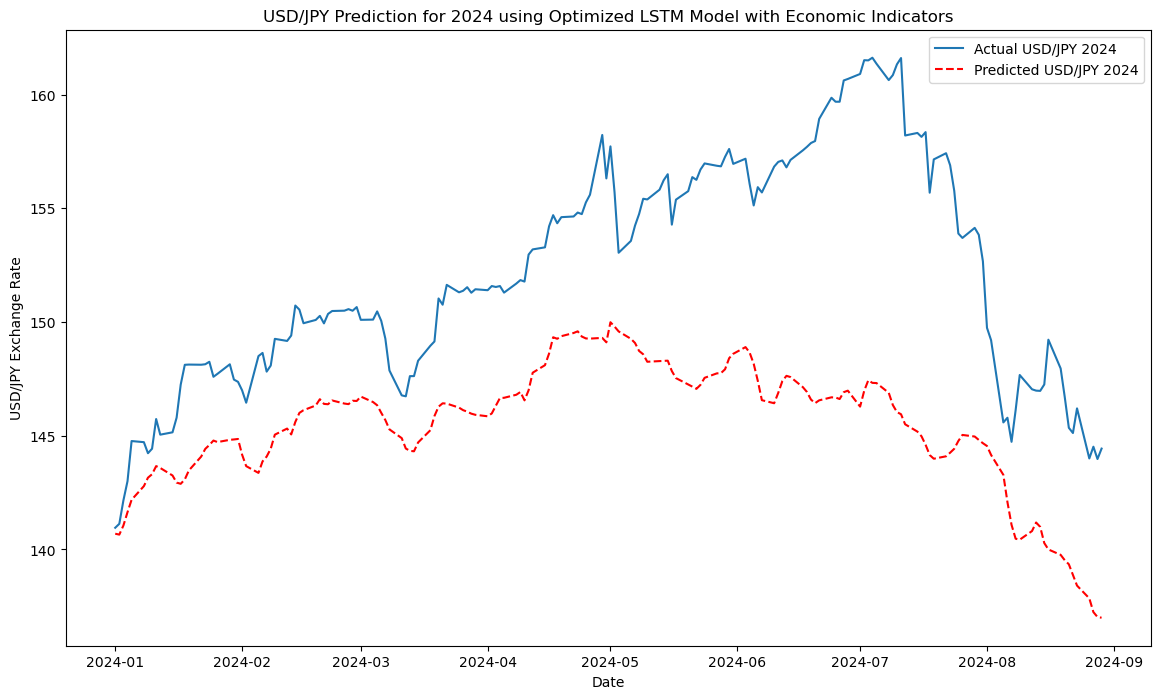

In [101]:

# Step 5: Evaluate the Model on 2024 Data

best_model = grid_result.best_estimator_

usd_jpy_predictions_2024_scaled = best_model.predict(X_test_scaled)
usd_jpy_predictions_2024 = scaler_y.inverse_transform(usd_jpy_predictions_2024_scaled.reshape(-1, 1)).flatten()

print("usd_jpy_predictions_2024: ", usd_jpy_predictions_2024.shape)

plt.figure(figsize=(14, 8))
plt.plot(y_test.index, y_test, label='Actual USD/JPY 2024')
plt.plot(y_test.index, usd_jpy_predictions_2024, color='r', linestyle='--', label='Predicted USD/JPY 2024')
plt.title('USD/JPY Prediction for 2024 using Optimized LSTM Model with Economic Indicators')
plt.xlabel('Date')
plt.ylabel('USD/JPY Exchange Rate')
plt.legend()
plt.show()
